# Building a computing environment 

In [3]:
!pip install tqdm ipywidgets joblib --quiet

In [4]:
!pip install wfdb neurokit2 --quiet

# Checking ECG test data on a stand-alone basis

Reading record: a01 from database: apnea-ecg

--- Record Header Info ---
Sampling frequency: 100 Hz
Signal names: ['ECG']
Signal units: ['mV']
Total record length: 60000 samples (0.2 hours)
Loaded signal shape: (60000, 1)
-------------------------
--- Apnea Annotations (in loaded range, first 5) ---
Annotation samples: [    0  6000 12000 18000 24000]
Annotation symbols: ['N', 'N', 'N', 'N', 'N']
Number of annotations in loaded range: 11
-------------------------


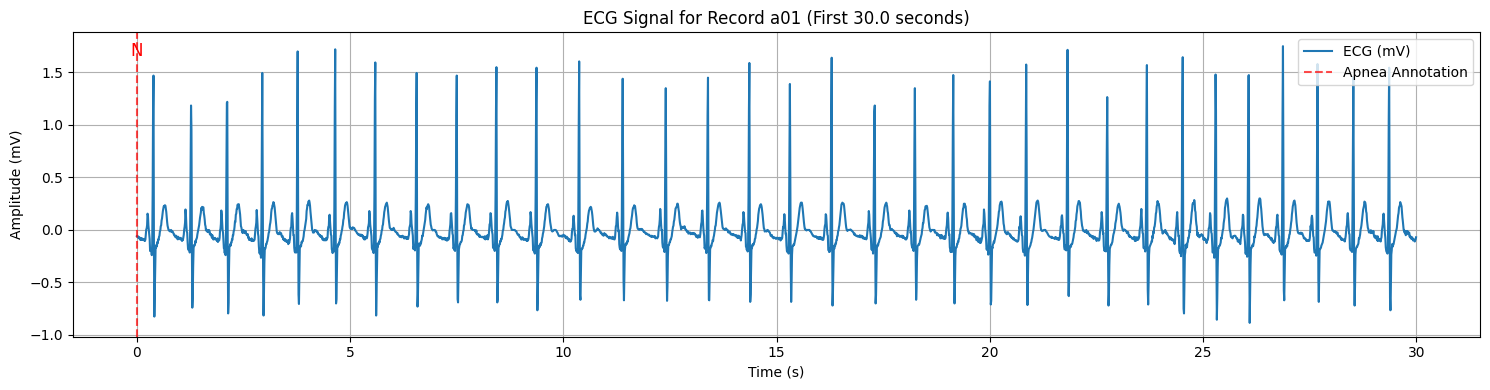

In [1]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np # Used for generating the time axis
import os

# --- Settings ---
record_name = 'a01'  # Record name to load (e.g., 'a01', 'c01', 'x01')
database_name = 'apnea-ecg'
db_version = '1.0.0' # Database version
pn_dir_path = f'{database_name}/{db_version}' # PhysioNet directory path

# Data storage directory (if not specified, uses wfdb default location)
# The wfdb library caches data, so it doesn't download every time.
# save_dir = 'wfdb_data'
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

print(f"Reading record: {record_name} from database: {database_name}")

# --- Read header information and signal data ---
try:
    # Read directly from PhysioNet (will attempt download if not found locally)
    # Specify the range to load using sampfrom, sampto (full data is large, so loading the first 10 mins = 600s * 100Hz = 60000 samples here)
    # Load in physical units (mV) using physical=True
    record = wfdb.rdrecord(record_name, pn_dir=pn_dir_path, sampfrom=0, sampto=60000, physical=True)

    # Get the loaded signal data (p_signal contains physical units)
    signal = record.p_signal
    # Get header information
    fs = record.fs
    sig_name = record.sig_name
    units = record.units
    record_len_samples = record.sig_len # This indicates the total length of the file

    print(f"\n--- Record Header Info ---")
    print(f"Sampling frequency: {fs} Hz")
    print(f"Signal names: {sig_name}")
    print(f"Signal units: {units}")
    print(f"Total record length: {record_len_samples} samples ({record_len_samples / fs / 3600:.1f} hours)")
    print(f"Loaded signal shape: {signal.shape}") # Shape of the loaded segment
    print("-" * 25)

    # --- Read apnoea annotations ---
    # Specify the apnoea annotation file using extension='apn'
    annotation = wfdb.rdann(record_name, extension='apn', pn_dir=pn_dir_path, sampfrom=0, sampto=60000)

    # Display annotation information (first few within the loaded range)
    print("--- Apnea Annotations (in loaded range, first 5) ---")
    print(f"Annotation samples: {annotation.sample[:5]}") # Sample numbers where annotations occur
    print(f"Annotation symbols: {annotation.symbol[:5]}") # Annotation symbols ('N': Normal breathing, 'A': Apnoea)
    print(f"Number of annotations in loaded range: {len(annotation.sample)}")
    print("-" * 25)

    # --- Simple plot (first 30 seconds) ---
    plot_duration_sec = 30
    plot_samples = int(plot_duration_sec * fs)

    # Adjust if the loaded signal is shorter than the plot range
    if plot_samples > signal.shape[0]:
        plot_samples = signal.shape[0]
        plot_duration_sec = plot_samples / fs

    if plot_samples > 0: # Only plot if data was loaded
        # Create the time axis (using NumPy)
        time_axis = np.arange(plot_samples) / fs

        plt.figure(figsize=(15, 4))
        # Apnea-ECG has one signal (ECG), access via signal[:, 0]
        plt.plot(time_axis, signal[:plot_samples, 0], label=f'{sig_name[0]} ({units[0]})')
        plt.title(f'ECG Signal for Record {record_name} (First {plot_duration_sec:.1f} seconds)')
        plt.xlabel('Time (s)')
        plt.ylabel(f'Amplitude ({units[0]})')

        # Plot annotations (only within the plot range)
        # Note: Annotations are provided per minute
        ann_indices_in_plot = [i for i, s in enumerate(annotation.sample) if s < plot_samples]
        if ann_indices_in_plot:
            ann_times = annotation.sample[ann_indices_in_plot] / fs
            ann_symbols = [annotation.symbol[i] for i in ann_indices_in_plot]
            # Draw vertical lines and symbols at annotation positions
            y_min, y_max = plt.ylim() # Get the current y-axis limits
            # Ensure legend handles are created only once
            has_legend_handle = 'Apnea Annotation' in plt.gca().get_legend_handles_labels()[1]
            for t, s in zip(ann_times, ann_symbols):
                # Vertical line at annotation position
                plt.axvline(t, color='red', linestyle='--', alpha=0.7, label='Apnea Annotation' if not has_legend_handle else "")
                has_legend_handle = True # Set flag after first use
                # Display annotation symbol near the top of the plot
                plt.text(t, y_max * 0.95, s, color='red', fontsize=12, ha='center', va='top')

        plt.grid(True)
        # Only show legend if annotation lines were added
        if 'Apnea Annotation' in plt.gca().get_legend_handles_labels()[1]:
             plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()
    else:
        print("No signal data loaded to plot.")

except Exception as e:
    print(f"\nError reading record {record_name} from {database_name}: {e}")
    print("Please ensure the 'wfdb' library is installed ('pip install wfdb').")
    print("An internet connection may be required for the first download.")
    print(f"Check if the database '{database_name}' and record '{record_name}' exist on PhysioNet.")

# Creating RRIs to feed into the Foundation Model

In [ ]:
import wfdb
import neurokit2 as nk
import numpy as np
import pandas as pd
# Import joblib for parallel processing
from joblib import Parallel, delayed
from tqdm import tqdm # tqdm for progress bar
import time
import os
import platform # To get os.cpu_count()

# --- Configuration ---
database_name = 'apnea-ecg'
db_version = '1.0.0'
pn_dir_path = f'{database_name}/{db_version}'
output_dir = 'apnea_ecg_rri_files'  # Directory to save the RRI files
target_fs = 100  # Target sampling frequency (Hz) for RRI calculation

# Number of parallel workers (adjust according to CPU cores)
# Using -1 tells joblib to use all available cores, -2 uses all but one.
# Be mindful of memory consumption. Let's keep the manual setting option too.
# num_workers = -2 # Use all cores but one (joblib recommendation)
num_workers = os.cpu_count() - 1 if os.cpu_count() and os.cpu_count() > 1 else 1
# num_workers = 4 # Manual override as in the previous example

# Full list of record names (a01-a20, b01-b05, c01-c05, x01-x30)
record_names_a = [f'a{i:02d}' for i in range(1, 21)]
record_names_b = [f'b{i:02d}' for i in range(1, 6)]
record_names_c = [f'c{i:02d}' for i in range(1, 6)]
record_names_x = [f'x{i:02d}' for i in range(1, 31)]
all_record_names = sorted(record_names_a + record_names_b + record_names_c + record_names_x)

print(f"Target database: {database_name}/{db_version}")
print(f"Total records to process: {len(all_record_names)}")
print(f"Output directory: {output_dir}")
print(f"Target sampling frequency for RRI: {target_fs} Hz")
print(f"Number of parallel workers (n_jobs for joblib): {num_workers}")

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# --- Function to process a single record and save RRI to a file ---
# This function remains the same as before
def process_and_save_rri(record_name, db_path, out_dir, fs_target):
    """
    Reads ECG for the specified record, preprocesses, extracts RRI (ms),
    and saves it to a CSV file.
    Returns: (record_name, success_status, message_or_filepath)
    """
    output_filepath = os.path.join(out_dir, f"{record_name}_rri.csv")
    start_time = time.time()
    try:
        # 1. Load data
        record = wfdb.rdrecord(record_name, pn_dir=db_path, physical=True)
        ecg_signal_original = record.p_signal[:, 0]
        fs_original = record.fs

        # 2. Resample (if necessary)
        if fs_original != fs_target:
            ecg_signal = nk.signal_resample(ecg_signal_original,
                                           sampling_rate=fs_original,
                                           desired_sampling_rate=fs_target,
                                           method='interpolation')
        else:
            ecg_signal = ecg_signal_original
        fs = fs_target

        # 3. NeuroKit2 for preprocessing and R-peak detection
        ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=fs, method="neurokit")
        _, rpeaks_info = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs, method="neurokit", correct_artifacts=True)
        rpeaks_indices = rpeaks_info['ECG_R_Peaks']

        # 4. Calculate RRI series (in milliseconds)
        if len(rpeaks_indices) > 1:
            rri_series_ms = np.diff(rpeaks_indices) / fs * 1000.0

            if len(rri_series_ms) > 0:
                # 5. Save to CSV file (no header, no index, single column)
                pd.Series(rri_series_ms).to_csv(output_filepath, index=False, header=False)
                duration = time.time() - start_time
                # Return success status and info message including the file path
                return record_name, True, f"Saved to {output_filepath} ({len(rri_series_ms)} RRIs, {duration:.2f}s)"
            else:
                duration = time.time() - start_time
                # Return failure status and message
                return record_name, False, f"No valid RRIs calculated after diff ({duration:.2f}s)"
        else:
            duration = time.time() - start_time
            # Return failure status and message
            return record_name, False, f"Not enough R-peaks found ({len(rpeaks_indices)}) ({duration:.2f}s)"

    except Exception as e:
        # Print the exception for debugging during development if needed
        print(f"Exception in process_and_save_rri for {record_name}: {e}")
        duration = time.time() - start_time
        # Return failure status and error message
        return record_name, False, f"Error: {e} ({duration:.2f}s)"

# --- Execute parallel processing using joblib ---
print(f"\nStarting parallel processing with joblib (n_jobs={num_workers})...")
start_total_time = time.time()

# Use joblib's Parallel and delayed functions
# Wrap the iterable (generator expression) with tqdm for progress display
results = Parallel(n_jobs=num_workers)(
    delayed(process_and_save_rri)(name, pn_dir_path, output_dir, target_fs)
    for name in tqdm(all_record_names, desc="Processing Records")
)

# 'results' will be a list containing the tuples returned by process_and_save_rri

end_total_time = time.time()
print(f"\n--- Parallel Processing Complete ---")
print(f"Total time: {end_total_time - start_total_time:.2f} seconds.")

# --- Summarise and display results ---
# This part remains the same as it processes the 'results' list
success_count = 0
failed_records = []
# Sort results alphabetically by record name for consistent output
for record_name_res, status, message in sorted(results):
    if status:
        success_count += 1
        # Optionally print success message:
        # print(f"[Success] {record_name_res}: {message}")
    else:
        failed_records.append((record_name_res, message))
        # Print details only for failed records
        print(f"[Failed] {record_name_res}: {message}")

print(f"\n--- Summary ---")
print(f"Successfully processed and saved RRI for {success_count} out of {len(all_record_names)} records.")
if failed_records:
    print(f"Failed to process {len(failed_records)} records.")
    # Optionally list failed records again:
    # for name, msg in failed_records:
    #     print(f"  - {name}: {msg}")
print(f"RRI data saved in directory: '{output_dir}' as individual CSV files (e.g., a01_rri.csv).")

print("\nThese CSV files can now be loaded individually for further analysis or model input preparation.")

# Submitting the created RRIs to Chronos to obtain forecast results

## Install missing modules

In [5]:
!pip install pandas matplotlib --quiet

In [6]:
!pip install gluonts torch transformers --quiet

In [7]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git --quiet

## Forecasting with Chronos and storing the results

In [ ]:
# === Part 1 Final (Revised based on user's code + necessary fixes + NPY saving) ===

import pandas as pd
import numpy as np
import torch
# import matplotlib.pyplot as plt # Plotting removed for focus on saving
import time
import os
import glob
# Use tqdm.notebook if in Jupyter/Colab, otherwise use standard tqdm
try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm
import warnings

# Ignore specific warnings if they become noisy (optional)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Attempt to import the ChronosPipeline
try:
    # This import depends on the chronos-ts package structure
    from chronos import ChronosPipeline
except ImportError:
    print("ERROR: Could not import ChronosPipeline.")
    print("Please ensure you have installed the required package, likely via:")
    print("pip install git+https://github.com/amazon-science/chronos-forecasting.git") # User's suggestion kept
    exit()

# --- 1. Configuration ---
original_rri_dir = 'apnea_ecg_rri_files'    # Directory with original RRI CSV files
predicted_npy_dir = 'apnea_ecg_rri_predicted_samples_chronos_npy' # Directory for Chronos prediction SAMPLES (.npy)
os.makedirs(predicted_npy_dir, exist_ok=True) # Create output directory for predictions

# Set prediction horizon (e.g., 1 hour for practicality)
prediction_horizon_hours = 1
# prediction_horizon_hours = 6 # Or uncomment this to try 6 hours (very long compute & large files)

context_hours = 1            # History length (e.g., 1 hour)
num_prediction_samples = 100 # Number of sample paths to generate for probabilistic forecast

# Choose the Chronos model size
model_checkpoint = "amazon/chronos-t5-small" # Smallest model for testing
# model_checkpoint = "amazon/chronos-t5-base" # Larger alternative

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Use bfloat16 for potential speed/memory improvements if GPU supports it
torch_dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8 else torch.float32

print(f"--- Chronos Prediction Sample Generation ---")
print(f"Using Chronos model: {model_checkpoint}")
print(f"Using device: {device}, dtype: {torch_dtype}")
print(f"Prediction horizon: {prediction_horizon_hours} hours")
print(f"Context window: {context_hours} hours")
print(f"Number of forecast samples: {num_prediction_samples}")
print(f"Loading original RRI from: {original_rri_dir}")
print(f"Saving predicted RRI samples to: {predicted_npy_dir} (as .npy files)")

# Get all original RRI file paths
all_original_rri_files = sorted(glob.glob(os.path.join(original_rri_dir, "*_rri.csv")))
if not all_original_rri_files:
    raise FileNotFoundError(f"No original RRI CSV files found in '{original_rri_dir}'. Run the RRI extraction script first.")
print(f"Found {len(all_original_rri_files)} original RRI files to process.")

# --- 2. Load Chronos Pipeline (once) ---
print(f"\nLoading Chronos pipeline for {model_checkpoint}...")
pipeline = None # Initialize pipeline variable
try:
    # Load the pipeline first. We will explicitly move it later.
    pipeline = ChronosPipeline.from_pretrained(
        model_checkpoint,
        device_map="auto",
        torch_dtype=torch_dtype,
    )
    # Optional: Check the device of a parameter to confirm
    print(f"Device of first param: {next(pipeline.model.parameters()).device}")
except Exception as e:
    print(f"\nError loading or moving Chronos pipeline: {e}")
    print("Please ensure 'chronos-ts', 'torch', 'transformers', and 'accelerate' are installed correctly.")
    exit()

# --- 3. Function to predict samples and save as .npy (with dtype/device fixes) ---
def predict_and_save_samples_chronos_final(rri_filepath, context_h, pred_h, pipeline_instance, pred_out_dir, num_samples, target_dtype, target_device):
    """
    Loads RRI, predicts samples using ChronosPipeline, saves ALL samples as .npy file.
    Includes fixes for previously observed dtype and device errors.
    Returns: (record_name, success_status, message)
    """
    record_name = os.path.basename(rri_filepath).replace('_rri.csv', '')
    output_filepath = os.path.join(pred_out_dir, f"{record_name}_rri_predicted_samples.npy")
    start_time = time.time()
    status = False
    message = "Prediction started"
    processed_shape = None

    # Make sure the pipeline exists and is usable
    if pipeline_instance is None:
         return record_name, False, "Skipped: Pipeline object is not available."

    try:
        # 1. Load original RRI
        rri_series_df = pd.read_csv(rri_filepath, header=None, names=['rri_ms'])
        rri_history = rri_series_df['rri_ms'].dropna().values
        min_hist_len = 10
        if len(rri_history) < min_hist_len:
             return record_name, False, f"Skipped: Insufficient history data ({len(rri_history)} < {min_hist_len})"

        # 2. Calculate context/prediction length
        mean_rri = np.mean(rri_history)
        avg_hr_bpm = 60 / (mean_rri / 1000) if mean_rri > 0 else 75
        # Calculate desired prediction length in samples
        pred_len_calculated = max(1, int(pred_h * 3600 * avg_hr_bpm / 60))
        ctx_len = max(1, int(context_h * 3600 * avg_hr_bpm / 60))

        # Ensure context length is valid
        if ctx_len >= len(rri_history):
            print(f"Warning for {record_name}: Requested context length ({ctx_len}) >= history length ({len(rri_history)}). Using history length - 1.")
            ctx_len = len(rri_history) - 1
        if ctx_len <= 0:
             return record_name, False, f"Skipped: Not enough history ({len(rri_history)}) for context_length calculation (needed > 0)"

        # 3. Prepare input context tensor (Applying dtype and device fixes)
        context_rri = rri_history[-ctx_len:]
        # Create tensor with the correct dtype determined during setup
        # Ensure input is float, even if original RRI was int
        context = torch.tensor(context_rri, dtype=torch.float32).to(target_dtype)
        # Explicitly move the tensor to the target device
        #context = context.to(target_device)
        # Add batch dimension: [ctx_len] -> [1, ctx_len]
        context = context.unsqueeze(0)

        # 4. Make prediction (generate samples) using the pipeline
        # Use the *calculated* prediction length here
        # NOTE: The previous code had a hardcoded '64'. Using the calculated length now.
        # If '64' was intentional, change pred_len_calculated below back to 64.
        forecast = pipeline_instance.predict(
            context,
            pred_len_calculated, # Use calculated prediction length
            num_samples=num_samples,
        )
        # Expected forecast shape: [1 (batch_size), num_samples, pred_len]

        if forecast is not None and forecast.ndim == 3 and \
           forecast.shape[0] == 1 and forecast.shape[1] == num_samples and forecast.shape[2] == pred_len_calculated:

            # Extract samples [num_samples, pred_len], move to CPU, convert to numpy
            # Squeeze the batch dimension before moving/converting
            prediction_samples = forecast.squeeze(0).cpu().numpy()

            # 5. Save ALL samples as a NumPy binary file (.npy)
            np.save(output_filepath, prediction_samples) # Save the 2D array
            status = True
            processed_shape = prediction_samples.shape
            duration = time.time() - start_time
            message = f"Saved prediction samples {processed_shape} to {output_filepath} ({duration:.2f}s)"
        else:
            duration = time.time() - start_time
            forecast_shape_str = str(getattr(forecast, 'shape', 'None')) # Safer shape printing
            message = f"Pipeline prediction failed or returned unexpected shape: {forecast_shape_str}. Expected: (1, {num_samples}, {pred_len_calculated}) ({duration:.2f}s)"

    except Exception as e:
        duration = time.time() - start_time
        # Improve error message for device issues
        err_msg = f"Error during prediction/saving for {record_name}: {type(e).__name__} - {e} ({duration:.2f}s)"
        if "Expected all tensors to be on the same device" in str(e):
            err_msg += f" [Device Check: Input Context on {context.device if 'context' in locals() else 'N/A'}, Pipeline expected on {target_device}]"
        message = err_msg
        status = False # Ensure status is False on exception

    return record_name, status, message

# --- 4. Loop through all files and predict (SEQUENTIAL execution) ---
print(f"\nStarting prediction loop for {len(all_original_rri_files)} records (SEQUENTIAL using ChronosPipeline)...")
prediction_results_chronos = []
start_pred_loop_time = time.time()

# Ensure the pipeline was loaded successfully before proceeding
if pipeline is None:
    print("ERROR: Chronos pipeline failed to load. Cannot start prediction loop.")
else:
    for fpath in tqdm(all_original_rri_files, desc="Predicting Samples with Chronos"):
        # Call the corrected function, passing torch_dtype and device
        res_name, res_status, res_msg = predict_and_save_samples_chronos_final(
            fpath, context_hours, prediction_horizon_hours, pipeline, predicted_npy_dir, num_prediction_samples, torch_dtype, device
        )
        prediction_results_chronos.append((res_name, res_status, res_msg))
        # Print status immediately for monitoring progress during long runs
        print(f"  Processed {res_name}: {'OK' if res_status else 'FAIL'} - {res_msg}")


    end_pred_loop_time = time.time()
    print(f"\n--- Chronos Prediction Loop Finished ---")
    print(f"Total prediction time: {end_pred_loop_time - start_pred_loop_time:.2f} seconds.")

    # --- 5. Summarise prediction results ---
    pred_success_count = sum(1 for _, status, _ in prediction_results_chronos if status)
    pred_failed_records = [(name, msg) for name, status, msg in prediction_results_chronos if not status]

    print(f"\nSuccessfully generated and saved Chronos prediction samples for {pred_success_count} out of {len(all_original_rri_files)} records.")
    if pred_failed_records:
        print(f"Failed to generate/save Chronos prediction samples for {len(pred_failed_records)} records:")
        # Optionally print details for failures (might be long, print first few)
        for i, (name, msg) in enumerate(pred_failed_records):
             print(f"  - {name}: {msg}")
             if i > 5: # Limit printing excessive errors
                 print("  - ... (further errors omitted)")
                 break
    print(f"\nPredicted RRI samples saved in directory: '{predicted_npy_dir}' as individual .npy files (e.g., a01_rri_predicted_samples.npy).")
    print("\nYou can now proceed to the HRV analysis (Part 2) using these .npy files.")
    print("REMEMBER: The HRV analysis code (Part 2) needs to load these .npy files and process the samples (e.g., calculate HRV per sample, then take median).")

## Statistical tests for the original RRI

In [ ]:
# === HRV Analysis and Comparison: Original (CSV) vs Predicted (NPY) [Parallelized] ===

import pandas as pd
import numpy as np
import neurokit2 as nk
from scipy.stats import mannwhitneyu
import os
import glob
from joblib import Parallel, delayed
import warnings
import time

# --- Configuration ---
original_rri_dir = 'apnea_ecg_rri_files' # Directory with original RRI CSV files

# Define record names for groups
record_names_low_ahi = [f'c{i:02d}' for i in range(1, 6)] + [f'x{i:02d}' for i in range(1, 31)] 
record_names_high_ahi = [f'a{i:02d}' for i in range(1, 21)] + [f'b{i:02d}' for i in range(1, 6)]

# Metrics to calculate and compare (using NeuroKit2 column names internally)
hrv_metrics_nk_names = ['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_DFA_alpha1']

# Mapping to user-friendly names for reporting results
metrics_display_map = {
    'HRV_MeanNN': 'Mean RRI (ms)',
    'HRV_SDNN': 'SDNN (ms)',
    'HRV_RMSSD': 'RMSSD (ms)',
    'HRV_DFA_alpha1': 'DFA Alpha 1'
}

# Number of parallel jobs (-1 uses all available cores)
N_JOBS = -1

# --- Ignore Warnings ---
warnings.filterwarnings('ignore', category=RuntimeWarning, module='neurokit2.*')
warnings.filterwarnings('ignore', category=UserWarning, module='pandas.*')
warnings.filterwarnings('ignore', category=FutureWarning)

# --- HRV Calculation Function (No change needed here) ---
def calculate_hrv_metrics(rri_ms, metrics_to_extract):
    """Calculates specified HRV metrics using NeuroKit2."""
    if not isinstance(rri_ms, np.ndarray):
        rri_ms = np.array(rri_ms)
    if rri_ms is None or len(rri_ms) < 50:
        return None
    if np.any(rri_ms <= 0) or np.nanstd(rri_ms) == 0:
        return None
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # Calculate standard HRV indices. NeuroKit2 efficiently calculates many at once.
            rri_ms = nk.intervals_to_peaks(rri_ms.flatten(), sampling_rate=100)
            hrv_indices = nk.hrv(rri_ms, sampling_rate=100) # sampling_rate is mainly for frequency domain bands
        # Combine results
        # Use .get() on the DataFrame returned, accessing the first row ([0])
        print(hrv_indices)
        metrics = {}
        if 'HRV_MeanNN' in metrics_to_extract:
            metrics['HRV_MeanNN'] = hrv_indices.get('HRV_MeanNN', pd.Series([np.nan])).iloc[0]
        if 'HRV_SDNN' in metrics_to_extract:
             metrics['HRV_SDNN'] = hrv_indices.get('HRV_SDNN', pd.Series([np.nan])).iloc[0]
        if 'HRV_RMSSD' in metrics_to_extract:
             metrics['HRV_RMSSD'] = hrv_indices.get('HRV_RMSSD', pd.Series([np.nan])).iloc[0]
        if 'HRV_DFA_alpha1' in metrics_to_extract:
             metrics['HRV_DFA_alpha1'] = hrv_indices.get('HRV_DFA_alpha1', pd.Series([np.nan])).iloc[0]

        # Filter only requested metrics that were successfully calculated
        final_metrics = {k: v for k, v in metrics.items() if k in metrics_to_extract and not pd.isna(v)}

        # Return None if no valid metrics were calculated
        return final_metrics if final_metrics else None

    except Exception as e:
        # Optional: More specific error logging if needed
        print(f" Debug: HRV calculation error for sample: {type(e).__name__} - {e}")
        return None


# --- Worker Function for CSV Processing ---
def process_single_csv_file(fpath, metrics_to_extract):
    """Processes a single CSV file to calculate HRV metrics."""
    record_name = os.path.basename(fpath).replace('_rri.csv', '')
    try:
        rri_df = pd.read_csv(fpath, header=None, names=['rri_ms'])
        rri_ms = rri_df['rri_ms'].dropna().values
        metrics = calculate_hrv_metrics(rri_ms, metrics_to_extract)
        if metrics is not None:
            return record_name, metrics
        else:
            # print(f"  Skipping {record_name} (CSV): Could not calculate valid metrics.") # Optional: uncomment for detailed skipping info
            return record_name, None
    except FileNotFoundError:
        print(f"  Warning: File not found {fpath}")
        return record_name, None
    except Exception as e:
        print(f"  Skipping {record_name} (CSV): Error during processing - {type(e).__name__}")
        return record_name, None

# --- Function to Analyze Group HRV from CSV files (Parallelized) ---
def analyze_group_hrv_csv_parallel(file_list, group_label, metrics_to_extract, n_jobs):
    """Loads original RRI CSV files, calculates HRV in parallel, returns DataFrame."""
    print(f"\nAnalyzing HRV for group: {group_label} (Original CSV data) using {n_jobs if n_jobs > 0 else 'all'} cores")
    hrv_results = []
    record_names_processed = []
    if not file_list:
        print(f"  No CSV files found for group {group_label}.")
        return pd.DataFrame()

    start_time = time.time()
    # Use joblib to parallelize the processing of each file
    # verbose=10 provides progress updates
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(process_single_csv_file)(fpath, metrics_to_extract) for fpath in file_list
    )
    end_time = time.time()
    print(f"  Parallel processing took {end_time - start_time:.2f} seconds.")

    # Collect results
    for result in results:
        if result is not None:
            record_name, metrics = result
            if metrics is not None:
                hrv_results.append(metrics)
                record_names_processed.append(record_name)

    if hrv_results:
        hrv_df = pd.DataFrame(hrv_results, index=record_names_processed)
        # Ensure all expected columns exist, fill with NaN if missing entirely
        for col in metrics_to_extract:
            if col not in hrv_df.columns:
                hrv_df[col] = np.nan
        # Reorder columns to match original request
        hrv_df = hrv_df[metrics_to_extract]
        print(f"  Successfully processed {len(hrv_df)} records for {group_label} (CSV).")
        return hrv_df
    else:
        print(f"  No valid HRV results could be calculated for {group_label} (CSV).")
        return pd.DataFrame()

# --- Function to Compare Groups and Perform Statistical Tests (No change needed here) ---
def compare_hrv_groups(df_low, df_high, metrics_map, label_suffix=""):
    """Performs Mann-Whitney U tests for specified metrics between two groups."""
    print(f"\n--- Statistical Comparison: Low AHI vs High AHI {label_suffix} ---")
    if not isinstance(df_low, pd.DataFrame) or df_low.empty or not isinstance(df_high, pd.DataFrame) or df_high.empty:
        print("Comparison skipped: One or both input dataframes are empty or invalid.")
        return None

    comparison_results = {}
    print(f"Comparing Low AHI (n={len(df_low.dropna(how='all'))}) vs High AHI (n={len(df_high.dropna(how='all'))}) using Mann-Whitney U test.") # Count non-NA rows
    print("-" * 80)
    print(f"{'Metric':<18} | {'Low Median (IQR)':<25} | {'High Median (IQR)':<25} | {'p-value':<10}")
    print("-" * 80)

    full_metrics_map = {**metrics_map, 'Mean HR (bpm)': 'Mean HR (bpm)'}

    for nk_name, display_name in full_metrics_map.items():
        is_hr = (display_name == 'Mean HR (bpm)')
        data_low, data_high = None, None

        if is_hr:
            mean_rri_col = 'HRV_MeanNN'
            if mean_rri_col in df_low.columns and mean_rri_col in df_high.columns:
                # Ensure division by zero doesn't happen and results are finite
                data_low_hr = (60000 / df_low[mean_rri_col].replace(0, np.nan)).dropna()
                data_high_hr = (60000 / df_high[mean_rri_col].replace(0, np.nan)).dropna()
                data_low_hr = data_low_hr[np.isfinite(data_low_hr)]
                data_high_hr = data_high_hr[np.isfinite(data_high_hr)]
                if len(data_low_hr) >= 3 and len(data_high_hr) >= 3:
                    data_low = data_low_hr
                    data_high = data_high_hr
                else:
                    print(f"{display_name:<18} | {'Low n<3' if len(data_low_hr)<3 else 'OK':<25} | {'High n<3' if len(data_high_hr)<3 else 'OK':<25} | {'N/A':<10}")
                    continue # Skip to next metric if not enough data for HR
            else:
                print(f"{display_name:<18} | {'Mean RRI missing':<25} | {'Mean RRI missing':<25} | {'N/A':<10}")
                continue # Skip HR calculation if Mean RRI is missing
        else:
            # Standard Handling for other metrics
            if nk_name not in df_low.columns or nk_name not in df_high.columns:
                print(f"{display_name:<18} | {'Metric missing':<25} | {'Metric missing':<25} | {'N/A':<10}")
                continue
            data_low_std = df_low[nk_name].dropna()
            data_high_std = df_high[nk_name].dropna()
            if len(data_low_std) >= 3 and len(data_high_std) >= 3:
                 data_low = data_low_std
                 data_high = data_high_std
            else:
                print(f"{display_name:<18} | {'Low n<3' if len(data_low_std)<3 else 'OK':<25} | {'High n<3' if len(data_high_std)<3 else 'OK':<25} | {'N/A':<10}")
                continue # Skip to next metric if not enough data

        # Perform test and print results if data is valid
        if data_low is not None and data_high is not None:
             try:
                 # Check for zero variance which Mann-Whitney U cannot handle
                 if np.nanstd(data_low) == 0 or np.nanstd(data_high) == 0:
                     print(f"{display_name:<18} | {'Zero variance data':<25} | {'Zero variance data':<25} | {'N/A':<10}")
                     comparison_results[display_name] = {'p_value': np.nan, 'error': 'Zero variance in data'}
                     continue

                 stat, p_value = mannwhitneyu(data_low, data_high, alternative='two-sided')
                 median_low, q1_low, q3_low = data_low.median(), data_low.quantile(0.25), data_low.quantile(0.75)
                 median_high, q1_high, q3_high = data_high.median(), data_high.quantile(0.25), data_high.quantile(0.75)
                 low_str = f"{median_low:.2f} ({q1_low:.2f}-{q3_low:.2f})"
                 high_str = f"{median_high:.2f} ({q1_high:.2f}-{q3_high:.2f})"
                 p_str = f"{p_value:.4f}{'*' if p_value < 0.05 else ' '}"
                 print(f"{display_name:<18} | {low_str:<25} | {high_str:<25} | {p_str:<10}")
                 comparison_results[display_name] = {'p_value': p_value}
             except ValueError as ve:
                 # Specifically catch cases where all values are identical (leads to ValueError in mannwhitneyu)
                 print(f"{display_name:<18} | {'Test error (e.g., identical values)':<25} | {'Test error':<25} | {'N/A':<10}")
                 comparison_results[display_name] = {'p_value': np.nan, 'error': str(ve)}
             except Exception as e:
                 print(f"{display_name:<18} | {'Error during test':<25} | {'Error during test':<25} | {'N/A':<10}")
                 comparison_results[display_name] = {'p_value': np.nan, 'error': str(e)}

    print("-" * 80)
    return comparison_results


# --- Main Execution Guard ---
if __name__ == "__main__":

    # == Step 1: Process and Compare Original CSV Data (Parallel) ==
    print("="*80)
    print(" STEP 1: Analyzing and Comparing Original RRI Data (CSV Files) - Parallel ".center(80, "="))
    print("="*80)

    # Find CSV files for each group
    original_files_low_csv = sorted([os.path.join(original_rri_dir, f"{name}_rri.csv") for name in record_names_low_ahi if os.path.exists(os.path.join(original_rri_dir, f"{name}_rri.csv"))])
    original_files_high_csv = sorted([os.path.join(original_rri_dir, f"{name}_rri.csv") for name in record_names_high_ahi if os.path.exists(os.path.join(original_rri_dir, f"{name}_rri.csv"))])

    # Calculate HRV for each group from CSVs using parallel processing
    hrv_original_low = analyze_group_hrv_csv_parallel(original_files_low_csv, "Low AHI", hrv_metrics_nk_names, n_jobs=N_JOBS)
    hrv_original_high = analyze_group_hrv_csv_parallel(original_files_high_csv, "High AHI", hrv_metrics_nk_names, n_jobs=N_JOBS)

    # Perform statistical comparison between groups for original data
    results_original = compare_hrv_groups(hrv_original_low, hrv_original_high, metrics_display_map, label_suffix="(Original CSV)")
    
    print("\n--- Analysis Finished ---")

========= Starting NPY HRV Analysis using All Samples and Mixed Models =========
Found 35 NPY files for Low AHI group.
Found 25 NPY files for High AHI group.

Analyzing HRV for group: Low AHI (Predicted NPY data - All Samples) using all cores


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
/home/ikari/workspace/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ikari/workspace/.venv/lib/python3.10/site-packages/neurokit2/hrv/hrv_time.py:237: RuntimeWarning: Mean of empty slice
  avg_rri.append(np.nanmean(rri[start_idx:end_idx]))
/home/ikari/workspace/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ikari/workspace/.venv/lib/python3.10/site-packages/neurokit2/hrv/hrv_time.py:237: RuntimeWarning: Mean of empty slice
  avg_rri.append(np.nanmean(rri[start_idx:end_idx]))
/home/ikari/workspace/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=a

KeyboardInterrupt: 

## Statistical tests for RRI of forecast results (tests based on linear regression due to multiple forecasts)

In [2]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 37.5 MB/s eta 0:00:00 0:00:01


In [4]:
# === Complete Code for NPY HRV Analysis using Mixed Models ===

import pandas as pd
import numpy as np
import neurokit2 as nk
import statsmodels.formula.api as smf # For Mixed Models
from scipy.stats import mannwhitneyu # Keep for potential original data comparison later
import os
import glob
from joblib import Parallel, delayed
import warnings
import time

# --- Configuration ---
predicted_npy_dir = 'apnea_ecg_rri_predicted_samples_chronos_npy'

# Define record names for groups (Adjust if your naming convention is different)
record_names_low_ahi = [f'c{i:02d}' for i in range(1, 6)] + [f'x{i:02d}' for i in range(1, 31)]
record_names_high_ahi = [f'a{i:02d}' for i in range(1, 21)] + [f'b{i:02d}' for i in range(1, 6)]

# Metrics to calculate and compare (using NeuroKit2 column names internally)
# Make sure these names match the output of nk.hrv() or how you extract them
hrv_metrics_nk_names = ['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_DFA_alpha1']

# Mapping to user-friendly names for reporting results
metrics_display_map = {
    'HRV_MeanNN': 'Mean RRI (ms)',
    'HRV_SDNN': 'SDNN (ms)',
    'HRV_RMSSD': 'RMSSD (ms)',
    'HRV_DFA_alpha1': 'DFA Alpha 1'
    # 'Mean HR (bpm)': 'Mean HR (bpm)' # Calculated separately if needed
}

# Number of parallel jobs (-1 uses all available cores)
N_JOBS = -1

# --- Ignore Warnings ---
warnings.filterwarnings('ignore', category=RuntimeWarning, module='neurokit2.*')
warnings.filterwarnings('ignore', category=UserWarning, module='pandas.*')
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='statsmodels.*') # Ignore statsmodels warnings if needed

# --- HRV Calculation Function (Assumes input is RRI in ms) ---
def calculate_hrv_metrics(rri_ms, metrics_to_extract):
    """Calculates specified HRV metrics using NeuroKit2 from RRI series."""
    if not isinstance(rri_ms, np.ndarray):
        rri_ms = np.array(rri_ms)
    # Basic validation of RRI series
    if rri_ms is None or len(rri_ms) < 50: # Need sufficient length for reliable HRV
        # print("Debug: RRI series too short or None.")
        return None
    if np.any(rri_ms <= 0) or np.nanstd(rri_ms) == 0: # Check for invalid values or zero variance
        # print("Debug: RRI series contains non-positive values or has zero standard deviation.")
        return None

    try:
        # Use NeuroKit2 to calculate HRV indices.
        peaks_indices = nk.intervals_to_peaks(rri_ms.flatten()) # Convert intervals back to peak locations if hrv needs it
        hrv_indices = nk.hrv(peaks_indices, sampling_rate=100) # Use sampling_rate of the *original* ECG if using peaks

        # Extract requested metrics from the resulting DataFrame
        metrics = {}
        if not isinstance(hrv_indices, pd.DataFrame) or hrv_indices.empty:
            # print("Debug: nk.hrv did not return a valid DataFrame.")
            return None

        # Extract values safely using .get() and accessing the first row .iloc[0]
        for nk_name in metrics_to_extract:
            # Check if column exists before trying to get value
            if nk_name in hrv_indices.columns:
                value = hrv_indices[nk_name].iloc[0]
                if not pd.isna(value): # Only store non-NaN values
                     metrics[nk_name] = value
            else:
                print(f"Debug: Metric {nk_name} not found in hrv_indices columns.")

        # Return the dictionary of calculated metrics, or None if empty
        return metrics if metrics else None

    except Exception as e:
        # More specific error logging can be helpful
        # print(f"Debug: HRV calculation failed - {type(e).__name__}: {e}")
        return None

# --- Worker Function for NPY Processing (Returns all samples) ---
def process_single_npy_file_all_samples(fpath, metrics_to_extract):
    """Processes a single NPY file, calculates HRV per sample, returns all results as a list of dicts."""
    record_name = os.path.basename(fpath).replace('_rri_predicted_samples.npy', '')
    try:
        predicted_samples = np.load(fpath) # Shape expected: (n_samples, n_timesteps) e.g., (100, 3647)
        # Validate shape and content
        if predicted_samples.ndim != 2 or predicted_samples.shape[0] == 0 or predicted_samples.shape[1] < 50:
            # print(f"  Skipping {record_name} (NPY): Invalid data shape {predicted_samples.shape} or length < 50.")
            return record_name, None
        num_samples = predicted_samples.shape[0]

        sample_hrv_metrics_list = []
        valid_sample_count = 0
        for i in range(num_samples): # Loop through each predicted sample row
            rri_sample_ms = predicted_samples[i, :]
            metrics = calculate_hrv_metrics(rri_sample_ms, metrics_to_extract)
            if metrics is not None:
                # Add identifying information to each sample's metrics
                metrics['sample_index'] = i
                metrics['record_name'] = record_name # Crucial for grouping in mixed model
                sample_hrv_metrics_list.append(metrics)
                valid_sample_count += 1

        # Optional: Add a check for minimum valid samples if desired, but generally return all valid ones
        # min_valid_samples_threshold = 10 # Example: require at least 10 valid samples out of 100
        # if valid_sample_count < min_valid_samples_threshold:
        #     print(f"  Skipping {record_name} (NPY): Insufficient valid samples ({valid_sample_count}/{num_samples}).")
        #     return record_name, None

        if sample_hrv_metrics_list:
            # Return the list of dictionaries, one for each valid sample's HRV
            return record_name, sample_hrv_metrics_list
        else:
            # print(f"  Skipping {record_name} (NPY): No valid HRV metrics calculated for any sample.")
            return record_name, None

    except FileNotFoundError:
        print(f"  Warning: NPY File not found {fpath}")
        return record_name, None
    except Exception as e:
        print(f"  Skipping {record_name} (NPY): Error during processing - {type(e).__name__}: {e}")
        return record_name, None

# --- Function to Analyze Group HRV from NPY files (Collects all samples) ---
def analyze_group_hrv_npy_all_samples_parallel(file_list, group_label, metrics_to_extract, n_jobs):
    """Loads predicted RRI NPY files, calculates HRV for all samples in parallel, returns a single DataFrame."""
    print(f"\nAnalyzing HRV for group: {group_label} (Predicted NPY data - All Samples) using {n_jobs if n_jobs > 0 else 'all'} cores")
    all_samples_hrv_results = [] # Stores dicts from all samples across all files
    if not file_list:
        print(f"  No NPY files found for group {group_label}.")
        return pd.DataFrame()

    start_time = time.time()
    # Parallel processing of each NPY file
    # results is a list of tuples: (record_name, list_of_sample_metrics_or_None)
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(process_single_npy_file_all_samples)(fpath, metrics_to_extract) for fpath in file_list
    )
    end_time = time.time()
    print(f"  Parallel processing took {end_time - start_time:.2f} seconds.")

    # Collect and flatten results into a single list of dictionaries
    processed_records_count = 0
    total_samples_count = 0
    for result in results:
        if result is not None:
            record_name, sample_metrics_list = result
            # Check if sample_metrics_list is a non-empty list
            if sample_metrics_list is not None and isinstance(sample_metrics_list, list) and sample_metrics_list:
                all_samples_hrv_results.extend(sample_metrics_list) # Add list of dicts
                processed_records_count += 1
                total_samples_count += len(sample_metrics_list)

    if all_samples_hrv_results:
        # Create a single DataFrame from the list of all sample metrics
        hrv_df = pd.DataFrame(all_samples_hrv_results)
        # Add the group label column
        hrv_df['group'] = group_label
        # Ensure all expected columns exist and set standard order
        expected_cols = ['record_name', 'group', 'sample_index'] + metrics_to_extract
        for col in expected_cols:
            if col not in hrv_df.columns:
                hrv_df[col] = np.nan # Add missing columns with NaN
        hrv_df = hrv_df[expected_cols] # Enforce column order
        print(f"  Successfully processed {processed_records_count} records, collecting {total_samples_count} total samples for {group_label} (NPY).")
        return hrv_df
    else:
        print(f"  No valid HRV results could be calculated for {group_label} (NPY - All Samples).")
        return pd.DataFrame()

# --- Function to Compare Groups using Mixed Effects Models ---
def compare_hrv_groups_mixed_model(df_all_samples, metrics_map, label_suffix=""):
    """Performs Linear Mixed Model comparisons for specified HRV metrics."""
    print(f"\n--- Statistical Comparison: Low AHI vs High AHI {label_suffix} (Mixed Model) ---")
    # Basic validation of the combined dataframe
    if not isinstance(df_all_samples, pd.DataFrame) or df_all_samples.empty:
        print("Comparison skipped: Input dataframe is empty or invalid.")
        return None
    if 'group' not in df_all_samples.columns or 'record_name' not in df_all_samples.columns:
         print("Comparison skipped: DataFrame must contain 'group' and 'record_name' columns.")
         return None
    if df_all_samples['group'].nunique() < 2:
         print("Comparison skipped: Need at least two groups in the 'group' column.")
         return None

    comparison_results = {}
    # Ensure 'group' is treated as a categorical variable
    df_all_samples['group'] = pd.Categorical(df_all_samples['group'])
    # Optional: Define reference group explicitly if needed, e.g., 'High AHI'
    # df_all_samples['group'] = df_all_samples['group'].cat.set_categories(['High AHI', 'Low AHI'])

    print(f"Comparing Low AHI vs High AHI using Linear Mixed Models.")
    print(f"Total samples analyzed: {len(df_all_samples)}")
    print(f"Unique records (subjects): {df_all_samples['record_name'].nunique()}")
    print("-" * 80)
    print(f"{'Metric':<18} | {'Group Effect (Low vs High)':<25} | {'Std. Error':<15} | {'z-value':<10} | {'p-value':<10}")
    print("-" * 80)

    # Iterate through metrics defined in the display map
    for nk_name, display_name in metrics_map.items():
         # Check if the metric column exists in the DataFrame
         if nk_name not in df_all_samples.columns:
             print(f"{display_name:<18} | {'Metric column missing':<25} | {'N/A':<15} | {'N/A':<10} | {'N/A':<10}")
             continue

         # Prepare data for the specific metric: drop rows where the metric, group, or record_name is NaN
         metric_data = df_all_samples[[nk_name, 'group', 'record_name']].dropna()

         # Check if enough data remains after dropping NaNs
         if len(metric_data) < 10 or metric_data['record_name'].nunique() < 2 or metric_data['group'].nunique() < 2:
              print(f"{display_name:<18} | {'Insufficient valid data':<25} | {'N/A':<15} | {'N/A':<10} | {'N/A':<10}")
              continue

         try:
             # Define the Linear Mixed Model formula:
             # Dependent_Variable ~ Fixed_Effect + (Random_Intercept | Grouping_Variable)
             # Here: HRV_Metric ~ Group + (1 | Subject_ID)
             # C(group, Treatment(reference='High AHI')) ensures 'group' is categorical
             # and sets 'High AHI' as the baseline for comparison.
             formula = f"{nk_name} ~ C(group, Treatment(reference='High AHI'))"

             # Define and fit the model
             # 'groups=metric_data["record_name"]' specifies the random intercepts for each subject
             model = smf.mixedlm(formula, metric_data, groups=metric_data["record_name"])
             result = model.fit(reml=False) # Use Maximum Likelihood (ML) for potentially comparing models

             # Extract results for the fixed effect of the group (Low AHI vs High AHI)
             # Find the coefficient corresponding to the 'Low AHI' level automatically
             low_ahi_coef_name = None
             for idx in result.summary().tables[1].index:
                 # Look for the coefficient name generated by statsmodels for the Low AHI level
                 if 'C(group, Treatment(reference=\'High AHI\'))[T.Low AHI]' in idx or ('group' in idx and 'Low AHI' in idx):
                     low_ahi_coef_name = idx
                     break

             if low_ahi_coef_name:
                 coef = result.params[low_ahi_coef_name]
                 stderr = result.bse[low_ahi_coef_name]
                 zvalue = result.tvalues[low_ahi_coef_name] # It's z-value for LMM
                 pvalue = result.pvalues[low_ahi_coef_name]

                 # Format results for printing
                 coef_str = f"{coef:.3f}"
                 stderr_str = f"{stderr:.3f}"
                 z_str = f"{zvalue:.2f}"
                 p_str = f"{pvalue:.4f}{'*' if pvalue < 0.05 else ' '}" # Add '*' if p < 0.05

                 print(f"{display_name:<18} | {coef_str:<25} | {stderr_str:<15} | {z_str:<10} | {p_str:<10}")
                 comparison_results[display_name] = {'coef': coef, 'stderr': stderr, 'zvalue': zvalue, 'p_value': pvalue}
             else:
                 print(f"{display_name:<18} | {'Low AHI effect N/F':<25} | {'N/A':<15} | {'N/A':<10} | {'N/A':<10}")
                 # print(result.summary()) # Print full summary for debugging if coefficient not found

         except np.linalg.LinAlgError:
             # Handle cases where the model fitting fails due to numerical issues (e.g., singular matrix)
              print(f"{display_name:<18} | {'Model fit failed (LinAlgError)':<25} | {'N/A':<15} | {'N/A':<10} | {'N/A':<10}")
              comparison_results[display_name] = {'p_value': np.nan, 'error': 'LinAlgError'}
         except Exception as e:
             # Catch other potential errors during model fitting
             print(f"{display_name:<18} | {'Model fit failed':<25} | {type(e).__name__:<15} | {'N/A':<10} | {'N/A':<10}")
             comparison_results[display_name] = {'p_value': np.nan, 'error': str(e)}

    print("-" * 80)
    return comparison_results


# --- Main Execution Block ---
if __name__ == "__main__":

    print("="*80)
    print(" Starting NPY HRV Analysis using All Samples and Mixed Models ".center(80, "="))
    print("="*80)

    # === Step 1: Find NPY Files for Each Group ===
    predicted_files_low_npy = []
    for name in record_names_low_ahi:
        fpath = os.path.join(predicted_npy_dir, f"{name}_rri_predicted_samples.npy")
        if os.path.exists(fpath):
            predicted_files_low_npy.append(fpath)
    print(f"Found {len(predicted_files_low_npy)} NPY files for Low AHI group.")

    predicted_files_high_npy = []
    for name in record_names_high_ahi:
         fpath = os.path.join(predicted_npy_dir, f"{name}_rri_predicted_samples.npy")
         if os.path.exists(fpath):
             predicted_files_high_npy.append(fpath)
    print(f"Found {len(predicted_files_high_npy)} NPY files for High AHI group.")

    if not predicted_files_low_npy and not predicted_files_high_npy:
        print("\nError: No NPY files found in the specified directory for either group. Exiting.")
        exit()

    # === Step 2: Calculate HRV for All Samples from NPY Files (Parallel) ===
    hrv_predicted_low_all = analyze_group_hrv_npy_all_samples_parallel(
        predicted_files_low_npy, "Low AHI", hrv_metrics_nk_names, n_jobs=N_JOBS
    )
    hrv_predicted_high_all = analyze_group_hrv_npy_all_samples_parallel(
        predicted_files_high_npy, "High AHI", hrv_metrics_nk_names, n_jobs=N_JOBS
    )

    # === Step 3: Combine Data and Perform Mixed Model Comparison ===
    hrv_predicted_all_samples = pd.DataFrame() # Initialize empty DataFrame
    # Check if both DataFrames are not empty before concatenating
    if isinstance(hrv_predicted_low_all, pd.DataFrame) and not hrv_predicted_low_all.empty and \
       isinstance(hrv_predicted_high_all, pd.DataFrame) and not hrv_predicted_high_all.empty:
        hrv_predicted_all_samples = pd.concat([hrv_predicted_low_all, hrv_predicted_high_all], ignore_index=True)
        print(f"\nCombined DataFrame created with {len(hrv_predicted_all_samples)} total samples.")

        # Perform the statistical comparison using the mixed model function
        results_predicted_mixed = compare_hrv_groups_mixed_model(
            hrv_predicted_all_samples,
            metrics_display_map, # Pass the map for display names
            label_suffix="(Predicted NPY - All Samples)"
        )
    elif isinstance(hrv_predicted_low_all, pd.DataFrame) and not hrv_predicted_low_all.empty:
        print("\nWarning: Data found only for Low AHI group. Cannot perform comparison.")
        # Optionally, you could analyze the single group data here if needed
        hrv_predicted_all_samples = hrv_predicted_low_all
    elif isinstance(hrv_predicted_high_all, pd.DataFrame) and not hrv_predicted_high_all.empty:
        print("\nWarning: Data found only for High AHI group. Cannot perform comparison.")
        hrv_predicted_all_samples = hrv_predicted_high_all
    else:
        print("\nError: Failed to gather HRV data from NPY files for both groups. Cannot proceed with comparison.")

    # === Step 4: (Optional) Save the combined DataFrame ===
    # if not hrv_predicted_all_samples.empty:
    #     try:
    #         save_path = "predicted_hrv_all_samples.csv"
    #         hrv_predicted_all_samples.to_csv(save_path, index=False)
    #         print(f"\nCombined HRV data saved to {save_path}")
    #     except Exception as e:
    #         print(f"\nError saving combined data: {e}")

    print("\n" + "="*80)
    print(" Analysis Finished ".center(80, "="))
    print("="*80)

========= Starting NPY HRV Analysis using All Samples and Mixed Models =========
Found 35 NPY files for Low AHI group.
Found 25 NPY files for High AHI group.

Analyzing HRV for group: Low AHI (Predicted NPY data - All Samples) using all cores


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
/home/ikari/workspace/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ikari/workspace/.venv/lib/python3.10/site-packages/neurokit2/hrv/hrv_time.py:237: RuntimeWarning: Mean of empty slice
  avg_rri.append(np.nanmean(rri[start_idx:end_idx]))
/home/ikari/workspace/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ikari/workspace/.venv/lib/python3.10/site-packages/neurokit2/hrv/hrv_time.py:237: RuntimeWarning: Mean of empty slice
  avg_rri.append(np.nanmean(rri[start_idx:end_idx]))
/home/ikari/workspace/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=a

  Parallel processing took 6425.15 seconds.
  Successfully processed 35 records, collecting 3358 total samples for Low AHI (NPY).

Analyzing HRV for group: High AHI (Predicted NPY data - All Samples) using all cores


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed: 107.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
/home/ikari/workspace/.venv/lib/python3.10/site-packages/neurokit2/hrv/hrv_time.py:237: RuntimeWarning: Mean of empty slice
  avg_rri.append(np.nanmean(rri[start_idx:end_idx]))
/home/ikari/workspace/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ikari/workspace/.venv/lib/python3.10/site-packages/neurokit2/hrv/hrv_time.py:237: RuntimeWarning: Mean of empty slice
  avg_rri.append(np.nanmean(rri[start_idx:end_idx]))
/home/ikari/workspace/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ikari/workspace/.venv/lib/python3.10/site-packages/neurokit2/hrv/hrv_time.py:237: Runt

  Parallel processing took 5978.46 seconds.
  Successfully processed 25 records, collecting 2441 total samples for High AHI (NPY).

Combined DataFrame created with 5799 total samples.

--- Statistical Comparison: Low AHI vs High AHI (Predicted NPY - All Samples) (Mixed Model) ---
Comparing Low AHI vs High AHI using Linear Mixed Models.
Total samples analyzed: 5799
Unique records (subjects): 60
--------------------------------------------------------------------------------
Metric             | Group Effect (Low vs High) | Std. Error      | z-value    | p-value   
--------------------------------------------------------------------------------
Mean RRI (ms)      | -192.455                  | 264.120         | -0.73      | 0.4662    
SDNN (ms)          | -106.480                  | 309.766         | -0.34      | 0.7310    
RMSSD (ms)         | 20.691                    | 110.941         | 0.19       | 0.8521    
DFA Alpha 1        | -0.160                    | 0.075           | -2.15    